This notebook produces IMF integrated metallicity dependent net yields. As an example we produce the default and alternative tables for the single sun+ best fit (which fix the SSP parameter). This notebook is just an example showing illustratively how to produce these yield tables. If you actually want to use these for your Chemical evolution model you will probably want to increase the time_steps and the mass_steps. You could also consult me to get an idea of sensible Parameters and yield sets that one could use. Mostly those ideas will be based on: http://adsabs.harvard.edu/abs/2018ApJ...861...40P

In [1]:
%pylab inline
import multiprocessing as mp

Populating the interactive namespace from numpy and matplotlib


In [2]:
from Chempy.parameter import ModelParameters
a = ModelParameters()

In [3]:
# Load solar abundances

from Chempy.solar_abundance import solar_abundances
basic_solar = solar_abundances()
getattr(basic_solar, 'Asplund09')()

# Initialise the SSP class with time-steps

time_steps = np.linspace(0.,13.5,521)

# Load the default yields

from Chempy.yields import SN2_feedback, AGB_feedback, SN1a_feedback
basic_sn2 = SN2_feedback()
getattr(basic_sn2, 'Nomoto2013_net')()
basic_1a = SN1a_feedback()
getattr(basic_1a, "Seitenzahl")()
basic_agb = AGB_feedback()
getattr(basic_agb, "Karakas_net_yield")()

# Load the alternative yields
alt_sn2 = SN2_feedback()
getattr(alt_sn2, 'chieffi04_net')()
alt_1a = SN1a_feedback()
getattr(alt_1a, "Thielemann")()
alt_agb = AGB_feedback()
getattr(alt_agb, "Ventura")()

# Use all elements that are traced

elements_to_trace = list(np.unique(basic_agb.elements+basic_sn2.elements+basic_1a.elements+alt_agb.elements+alt_sn2.elements+alt_1a.elements))
#elements_to_trace = ['H','He','C','N','O','Na','Al','Mg','Si','Ca','Ti','Mn','Fe','Ba','Ne']
print('all the traced elements: ',elements_to_trace)

# Producing the SSP birth elemental fractions (here we use solar)

solar_fractions = []
elements = np.hstack(basic_solar.all_elements)
for item in elements_to_trace:
    solar_fractions.append(float(basic_solar.fractions[np.where(elements==item)]))



all the traced elements:  ['Al', 'Ar', 'As', 'B', 'Be', 'Br', 'C', 'Ca', 'Cl', 'Co', 'Cr', 'Cu', 'F', 'Fe', 'Ga', 'Ge', 'H', 'He', 'K', 'Kr', 'Li', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Ne', 'Ni', 'O', 'P', 'Rb', 'S', 'Sc', 'Se', 'Si', 'Sr', 'Ti', 'V', 'Y', 'Zn', 'Zr']


In [4]:
# yieldset default
a.yield_table_name_sn2 = 'Nomoto2013_net'
a.yield_table_name_agb = 'Karakas_net_yield'
a.yield_table_name_1a = 'Seitenzahl'
# yieldset alternative
#a.yield_table_name_sn2 = 'chieffi04_net'
#a.yield_table_name_agb = 'Ventura'
#a.yield_table_name_1a = 'Thielemann'

# imf parameters
a.only_net_yields_in_process_tables = True
a.imf_type_name = 'Chabrier_2'
#default
a.high_mass_slope = -2.46
#alternative
#a.high_mass_slope = -2.51
a.imf_parameter = (22.8978, 716.4, 0.25, a.high_mass_slope)
a.mmin = 0.1
a.mmax = 100
# 100,000,000 mass steps are smooth enough for 1000 time steps
a.mass_steps = 200000 #2000 # 200000
a.sn2mmin = 8.
a.sn2mmax = 100.
a.bhmmin = float(a.sn2mmax) ## maximum of hypernova
a.bhmmax = float(a.mmax) ## maximum of the IMF

# sn1a delay parameters for maoz
#default
a.N_0 = np.power(10,-3.07)
a.sn1a_time_delay = np.power(10,-0.8)
#alternative
#a.N_0 = np.power(10,-3.49)
#a.sn1a_time_delay = np.power(10,-0.88)

a.sn1a_exponent = 1.12
a.dummy = 0.0
a.sn1a_parameter = [a.N_0,a.sn1a_time_delay,a.sn1a_exponent,a.dummy]
######################## END OF SETTING CHEMPY PARAMETER FOR SSP YIELD TABLE PRODUCTION

In [5]:
list_of_metallicities = np.logspace(-4,-2,2)
list_of_SSP_tables = []
list_of_SSP_tables.append(list_of_metallicities)
list_of_SSP_tables.append(time_steps)

from Chempy.wrapper import SSP_wrap


def create_one_SSP_table(parameters):
    differential_table = True # True is the default Chempy behaviour
    metallicity = parameters
    print(metallicity,a.yield_table_name_sn2)
    basic_ssp = SSP_wrap(a)
    basic_ssp.calculate_feedback(metallicity,list(elements_to_trace),list(solar_fractions),np.copy(time_steps))

    x = basic_ssp.agb_table
    y = basic_ssp.sn1a_table
    z = basic_ssp.sn2_table
    s = basic_ssp.bh_table
    d = basic_ssp.table

    u = np.zeros_like(x)
    names = list(u.dtype.names)

    # here we still add all processes, but we can also make individual process contribution to element
    for j,jtem in enumerate(names):
        u[jtem] = x[jtem] + y[jtem] + z[jtem] + s[jtem]
    if differential_table:
        for el in elements_to_trace:
            d[el] = u[el]
    else:
        for el in elements_to_trace:
            d[el] = np.cumsum(u[el])
        for name in ['mass_of_ms_stars_dying', 'mass_in_remnants', 'sn2', 'sn1a', 'pn', 'bh', 'hydrogen_mass_accreted_onto_white_dwarfs', 'unprocessed_ejecta']:
            d[name] = np.cumsum(d[name])
    return(d)

In [6]:
print("There are %d CPUs on this machine" % mp.cpu_count())
number_processes = max(1,mp.cpu_count() - 1)
pool = mp.Pool(number_processes)
results = pool.map(create_one_SSP_table, list_of_metallicities)
pool.close()
pool.join()

list_of_SSP_tables.append(results)
np.save('data/paper_1_ssp_tables/SSP_tables_default', list_of_SSP_tables)

There are 8 CPUs on this machine
0.0001 Nomoto2013_net
0.01 Nomoto2013_net


In [7]:
print('the metallicities for which SSP yield tables were calculated: ',list_of_SSP_tables[0])
print('metallicities: ',len(list_of_SSP_tables[2]))
print('timesteps: ', len(list_of_SSP_tables[2][0]), '= ', len(list_of_SSP_tables[1]))

the metallicities for which SSP yield tables were calculated:  [0.0001 0.01  ]
metallicities:  2
timesteps:  521 =  521


In [8]:
print('the data type of the SSP yield table: ',list_of_SSP_tables[2][0].dtype)
x = list_of_SSP_tables[2][0]
z = list_of_SSP_tables[2][1]

the data type of the SSP yield table:  (numpy.record, [('mass_of_ms_stars_dying', '<f8'), ('mass_in_ms_stars', '<f8'), ('mass_in_remnants', '<f8'), ('sn2', '<f8'), ('sn1a', '<f8'), ('pn', '<f8'), ('bh', '<f8'), ('hydrogen_mass_accreted_onto_white_dwarfs', '<f8'), ('unprocessed_ejecta', '<f8'), ('Al', '<f8'), ('Ar', '<f8'), ('As', '<f8'), ('B', '<f8'), ('Be', '<f8'), ('Br', '<f8'), ('C', '<f8'), ('Ca', '<f8'), ('Cl', '<f8'), ('Co', '<f8'), ('Cr', '<f8'), ('Cu', '<f8'), ('F', '<f8'), ('Fe', '<f8'), ('Ga', '<f8'), ('Ge', '<f8'), ('H', '<f8'), ('He', '<f8'), ('K', '<f8'), ('Kr', '<f8'), ('Li', '<f8'), ('Mg', '<f8'), ('Mn', '<f8'), ('Mo', '<f8'), ('N', '<f8'), ('Na', '<f8'), ('Nb', '<f8'), ('Ne', '<f8'), ('Ni', '<f8'), ('O', '<f8'), ('P', '<f8'), ('Rb', '<f8'), ('S', '<f8'), ('Sc', '<f8'), ('Se', '<f8'), ('Si', '<f8'), ('Sr', '<f8'), ('Ti', '<f8'), ('V', '<f8'), ('Y', '<f8'), ('Zn', '<f8'), ('Zr', '<f8')])


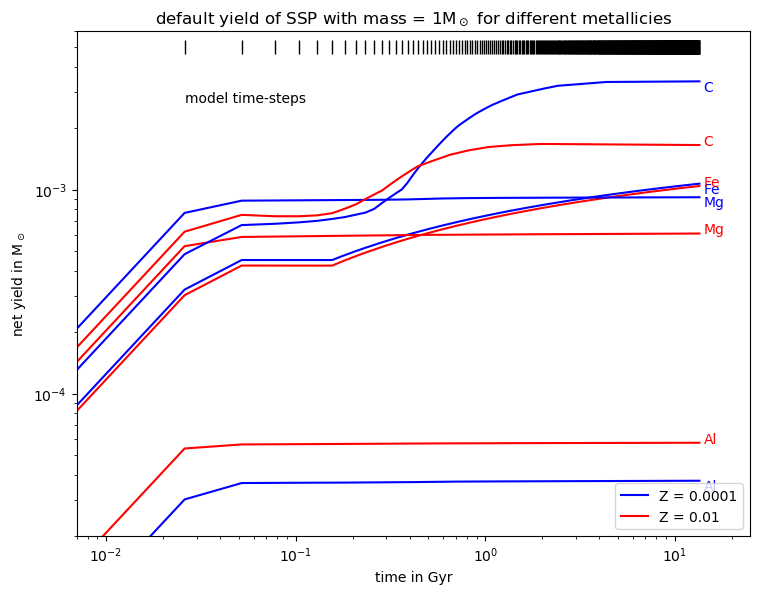

In [9]:
alpha = 0.5
factor = 1.05

## Actual plotting

fig = plt.figure(figsize=(8.69,6.69), dpi=100)
ax = fig.add_subplot(111)
ax.plot(time_steps,np.cumsum(x["Fe"]),'b', label = 'Z = 0.0001')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(x["Fe"])*0.9) ,s = 'Fe',color = 'b')
ax.plot(time_steps,np.cumsum(z["Fe"]), 'r', label = 'Z = 0.01')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(z["Fe"])) ,s = 'Fe',color = 'r')

ax.plot(time_steps,np.cumsum(x["Mg"]),'b')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(x["Mg"])*0.9) ,s = 'Mg',color = 'b')
ax.plot(time_steps,np.cumsum(z["Mg"]), 'r')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(z["Mg"])) ,s = 'Mg',color = 'r')

ax.plot(time_steps,np.cumsum(x["Al"]),'b')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(x["Al"])*0.9) ,s = 'Al',color = 'b')
ax.plot(time_steps,np.cumsum(z["Al"]), 'r')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(z["Al"])) ,s = 'Al',color = 'r')

ax.plot(time_steps,np.cumsum(x["C"]),'b')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(x["C"])*0.9) ,s = 'C',color = 'b')
ax.plot(time_steps,np.cumsum(z["C"]), 'r')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(z["C"])) ,s = 'C',color = 'r')

ax.plot(time_steps,np.ones_like(time_steps)*5e-3,marker = '|', markersize = 10, linestyle = '', color = 'k', alpha = 2*alpha)#, label = 'time-steps')
ax.annotate(xy = (time_steps[1],2.7e-3),s = 'model time-steps', color = 'k', alpha = 2*alpha)
ax.legend(loc = 'best')

ax.set_ylim(2e-5,6e-3)
ax.set_xlim(7e-3,25)
ax.set_title(r'default yield of SSP with mass = 1M$_\odot$ for different metallicies')
ax.set_ylabel(r"net yield in M$_\odot$")
ax.set_xlabel("time in Gyr")

ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [10]:
# yieldset alternative
a.yield_table_name_sn2 = 'chieffi04_net'
a.yield_table_name_agb = 'Ventura'
a.yield_table_name_1a = 'Thielemann'

a.high_mass_slope = -2.51
a.imf_parameter = (22.8978, 716.4, 0.25, a.high_mass_slope)
a.N_0 = np.power(10,-3.49)
a.sn1a_time_delay = np.power(10,-0.88)
a.sn1a_parameter = [a.N_0,a.sn1a_time_delay,a.sn1a_exponent,a.dummy]
######################## END OF SETTING CHEMPY PARAMETER FOR SSP YIELD TABLE PRODUCTION

list_of_SSP_tables_alt = []
list_of_SSP_tables_alt.append(list_of_metallicities)
list_of_SSP_tables_alt.append(time_steps)

print("There are %d CPUs on this machine" % mp.cpu_count())
number_processes = max(1,mp.cpu_count() - 1)
pool = mp.Pool(number_processes)
results = pool.map(create_one_SSP_table, list_of_metallicities)
pool.close()
pool.join()

list_of_SSP_tables_alt.append(results)
np.save('data/paper_1_ssp_tables/SSP_tables_alternative', list_of_SSP_tables_alt)

There are 8 CPUs on this machine
0.01 chieffi04_net
0.0001 chieffi04_net


In [11]:
print('the data type of the SSP yield table: ',list_of_SSP_tables[2][0].dtype)
y = list_of_SSP_tables_alt[2][1]

the data type of the SSP yield table:  (numpy.record, [('mass_of_ms_stars_dying', '<f8'), ('mass_in_ms_stars', '<f8'), ('mass_in_remnants', '<f8'), ('sn2', '<f8'), ('sn1a', '<f8'), ('pn', '<f8'), ('bh', '<f8'), ('hydrogen_mass_accreted_onto_white_dwarfs', '<f8'), ('unprocessed_ejecta', '<f8'), ('Al', '<f8'), ('Ar', '<f8'), ('As', '<f8'), ('B', '<f8'), ('Be', '<f8'), ('Br', '<f8'), ('C', '<f8'), ('Ca', '<f8'), ('Cl', '<f8'), ('Co', '<f8'), ('Cr', '<f8'), ('Cu', '<f8'), ('F', '<f8'), ('Fe', '<f8'), ('Ga', '<f8'), ('Ge', '<f8'), ('H', '<f8'), ('He', '<f8'), ('K', '<f8'), ('Kr', '<f8'), ('Li', '<f8'), ('Mg', '<f8'), ('Mn', '<f8'), ('Mo', '<f8'), ('N', '<f8'), ('Na', '<f8'), ('Nb', '<f8'), ('Ne', '<f8'), ('Ni', '<f8'), ('O', '<f8'), ('P', '<f8'), ('Rb', '<f8'), ('S', '<f8'), ('Sc', '<f8'), ('Se', '<f8'), ('Si', '<f8'), ('Sr', '<f8'), ('Ti', '<f8'), ('V', '<f8'), ('Y', '<f8'), ('Zn', '<f8'), ('Zr', '<f8')])


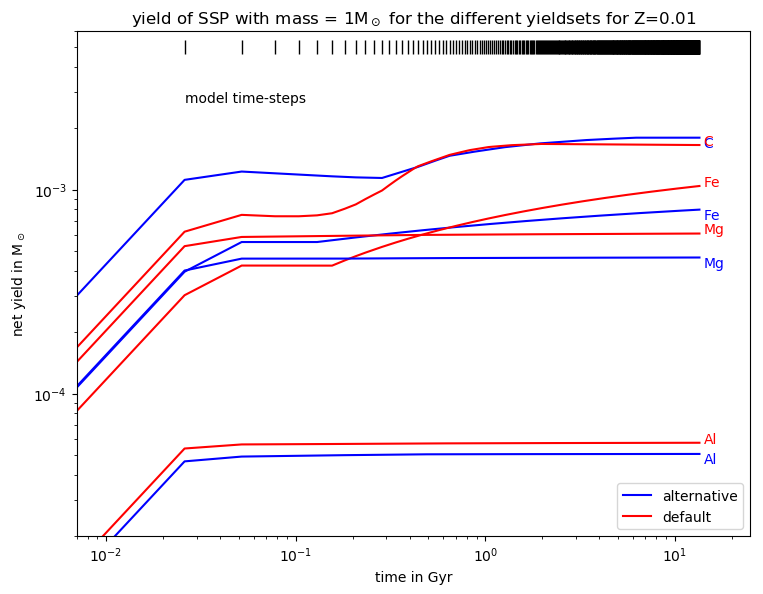

In [12]:
## Actual plotting

fig = plt.figure(figsize=(8.69,6.69), dpi=100)
ax = fig.add_subplot(111)
ax.plot(time_steps,np.cumsum(y["Fe"]),'b', label = 'alternative')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(y["Fe"])*0.9) ,s = 'Fe',color = 'b')
ax.plot(time_steps,np.cumsum(z["Fe"]), 'r', label = 'default')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(z["Fe"])) ,s = 'Fe',color = 'r')

ax.plot(time_steps,np.cumsum(y["Mg"]),'b')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(y["Mg"])*0.9) ,s = 'Mg',color = 'b')
ax.plot(time_steps,np.cumsum(z["Mg"]), 'r')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(z["Mg"])) ,s = 'Mg',color = 'r')

ax.plot(time_steps,np.cumsum(y["Al"]),'b')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(y["Al"])*0.9) ,s = 'Al',color = 'b')
ax.plot(time_steps,np.cumsum(z["Al"]), 'r')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(z["Al"])) ,s = 'Al',color = 'r')

ax.plot(time_steps,np.cumsum(y["C"]),'b')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(y["C"])*0.9) ,s = 'C',color = 'b')
ax.plot(time_steps,np.cumsum(z["C"]), 'r')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(z["C"])) ,s = 'C',color = 'r')

ax.plot(time_steps,np.ones_like(time_steps)*5e-3,marker = '|', markersize = 10, linestyle = '', color = 'k', alpha = 2*alpha)#, label = 'time-steps')
ax.annotate(xy = (time_steps[1],2.7e-3),s = 'model time-steps', color = 'k', alpha = 2*alpha)
ax.legend(loc = 'best')

ax.set_ylim(2e-5,6e-3)
ax.set_xlim(7e-3,25)
ax.set_title(r'yield of SSP with mass = 1M$_\odot$ for the different yieldsets for Z=0.01')
ax.set_ylabel(r"net yield in M$_\odot$")
ax.set_xlabel("time in Gyr")

ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

Beware, that both yieldsets for optimized to reproduce solar abundances, so in fact they look more similar here than they actually are, because the IMF and SNIa contribution is different. If you want to see the difference for the same SSP parameters check Paper 1 figure 4.

In [13]:
### so what is actually in these files:
print('these are the respective metal mass fractions for which the SSP yield tables were calculated')
print(list_of_SSP_tables[0])

these are the respective metal mass fractions for which the SSP yield tables were calculated
[0.0001 0.01  ]


In [14]:
print('these are the %d timesteps for which the yield was calculated. It is the time after SSP birth in Gyrs starting at 0 and going up to 13.5Gyrs' %(len(list_of_SSP_tables[1])))
print(list_of_SSP_tables[1])

these are the 521 timesteps for which the yield was calculated. It is the time after SSP birth in Gyrs starting at 0 and going up to 13.5Gyrs
[ 0.          0.02596154  0.05192308  0.07788462  0.10384615  0.12980769
  0.15576923  0.18173077  0.20769231  0.23365385  0.25961538  0.28557692
  0.31153846  0.3375      0.36346154  0.38942308  0.41538462  0.44134615
  0.46730769  0.49326923  0.51923077  0.54519231  0.57115385  0.59711538
  0.62307692  0.64903846  0.675       0.70096154  0.72692308  0.75288462
  0.77884615  0.80480769  0.83076923  0.85673077  0.88269231  0.90865385
  0.93461538  0.96057692  0.98653846  1.0125      1.03846154  1.06442308
  1.09038462  1.11634615  1.14230769  1.16826923  1.19423077  1.22019231
  1.24615385  1.27211538  1.29807692  1.32403846  1.35        1.37596154
  1.40192308  1.42788462  1.45384615  1.47980769  1.50576923  1.53173077
  1.55769231  1.58365385  1.60961538  1.63557692  1.66153846  1.6875
  1.71346154  1.73942308  1.76538462  1.79134615  1.8173076

In [15]:
print('in the last index of list_of_SSP_tables the actual tables are stored. For each metallicity there is one corresponding table in the same order. Therefore we have to tables')
len(list_of_SSP_tables[2])

in the last index of list_of_SSP_tables the actual tables are stored. For each metallicity there is one corresponding table in the same order. Therefore we have to tables


2

In [16]:
print("let's have a look at the table calculated for 0.01 metallicity:")
y = list_of_SSP_tables[2][1]
time = list_of_SSP_tables[1]
print(len(y), len(time),y.dtype.names)
print('we see that it has a length of the number of timesteps. So each entry corresponds to the respective timestep')

let's have a look at the table calculated for 0.01 metallicity:
521 521 ('mass_of_ms_stars_dying', 'mass_in_ms_stars', 'mass_in_remnants', 'sn2', 'sn1a', 'pn', 'bh', 'hydrogen_mass_accreted_onto_white_dwarfs', 'unprocessed_ejecta', 'Al', 'Ar', 'As', 'B', 'Be', 'Br', 'C', 'Ca', 'Cl', 'Co', 'Cr', 'Cu', 'F', 'Fe', 'Ga', 'Ge', 'H', 'He', 'K', 'Kr', 'Li', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Ne', 'Ni', 'O', 'P', 'Rb', 'S', 'Sc', 'Se', 'Si', 'Sr', 'Ti', 'V', 'Y', 'Zn', 'Zr')
we see that it has a length of the number of timesteps. So each entry corresponds to the respective timestep


lets have a look at the different fields:
as you can see the differential values are given, i.e. the amount of change per time interval, except for "mass_in_ms_stars" which gives the actual fraction
note also all values are given in mass fraction, i.e. normed to 1Msun(, as if the SSP had a mass of 1Msun)


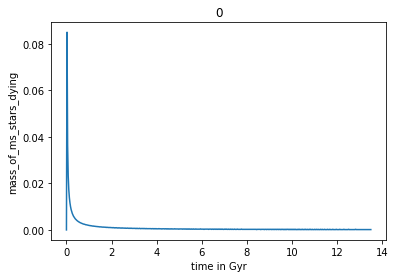

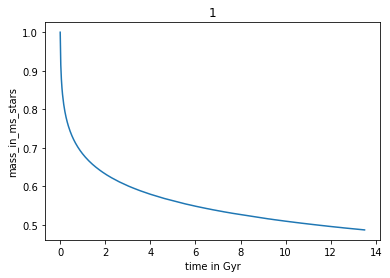

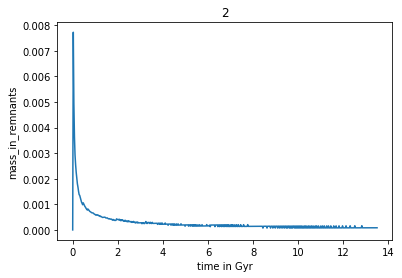

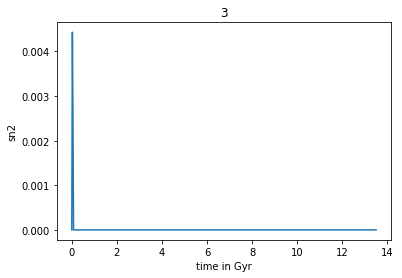

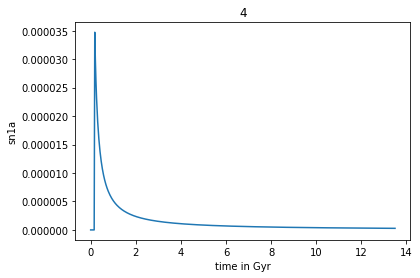

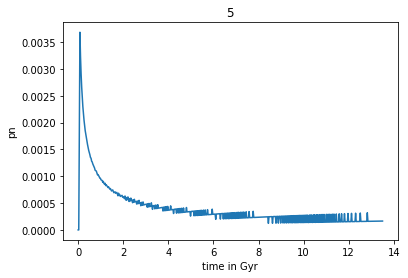

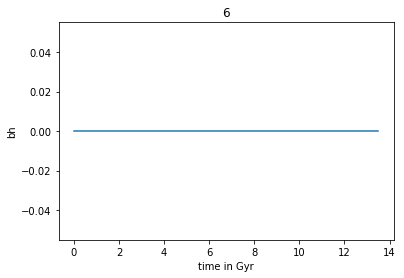

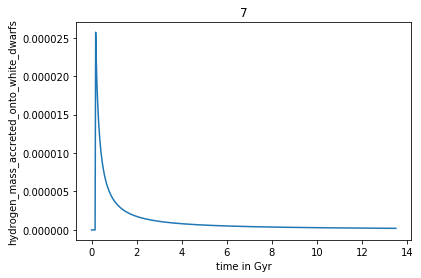

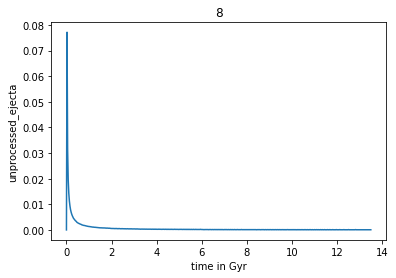

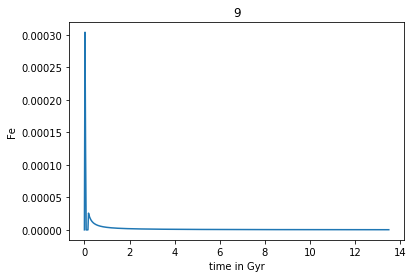

In [17]:
print('lets have a look at the different fields:')
print('as you can see the differential values are given, i.e. the amount of change per time interval, except for "mass_in_ms_stars" which gives the actual fraction')
print('note also all values are given in mass fraction, i.e. normed to 1Msun(, as if the SSP had a mass of 1Msun)')
fields = ['mass_of_ms_stars_dying', 'mass_in_ms_stars', 'mass_in_remnants', 'sn2', 'sn1a', 'pn', 'bh', 'hydrogen_mass_accreted_onto_white_dwarfs', 'unprocessed_ejecta', 'Fe']
for i,item in enumerate(fields):
    plt.plot(time,y[item])
    plt.xlabel('time in Gyr')
    plt.ylabel(item)
    plt.title(i)
    plt.show()
    plt.clf()
    plt.close()

beware that for "mass_in_ms_stars" we do not need to use the cumulative sum


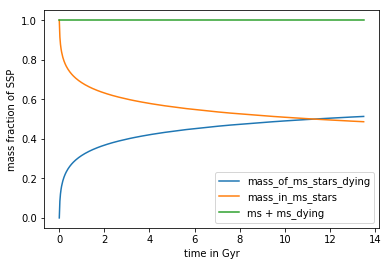

In [18]:
plt.plot(time,np.cumsum(y[fields[0]]), label=fields[0])
plt.plot(time,y[fields[1]],label = fields[1])
plt.plot(time,np.cumsum(y[fields[0]])+y[fields[1]],label = 'ms + ms_dying')
plt.legend()
plt.xlabel('time in Gyr')
plt.ylabel('mass fraction of SSP')
print('beware that for "mass_in_ms_stars" we do not need to use the cumulative sum')

'unprocessed_ejecta' should be everything that is not turned into remnants and dies (for net yields)
'hydrogen_mass_accreted_onto_white_dwarfs', probably negligible but for mass conservation for each supernova type 1a we remove remnant mass of 0.6Msun and add the missing 0.84Msun in form of hydrogen


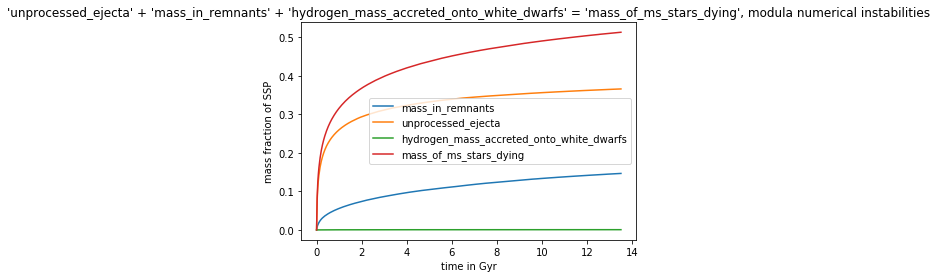

In [19]:
plt.plot(time,np.cumsum(y[fields[2]]), label=fields[2])
plt.plot(time,np.cumsum(y[fields[8]]), label=fields[8])
plt.plot(time,np.cumsum(y[fields[7]]), label=fields[7])
plt.plot(time,np.cumsum(y[fields[0]]), label=fields[0])
plt.legend()
plt.title("'unprocessed_ejecta' + 'mass_in_remnants' + 'hydrogen_mass_accreted_onto_white_dwarfs' = 'mass_of_ms_stars_dying', modula numerical instabilities")
plt.xlabel('time in Gyr')
plt.ylabel('mass fraction of SSP')
print("'unprocessed_ejecta' should be everything that is not turned into remnants and dies (for net yields)")
print("'hydrogen_mass_accreted_onto_white_dwarfs', probably negligible but for mass conservation for each supernova type 1a we remove remnant mass of 0.6Msun and add the missing 0.84Msun in form of hydrogen")

These are no mass fractions but occurence rate per 1Msun of SSP.
Over a Hubble time, per 1Msun of SSP we have approximately 0.1 Planetary nebula, 0.01 SNII, 0.001 SN1a. Black holes were not used in this SPP generation


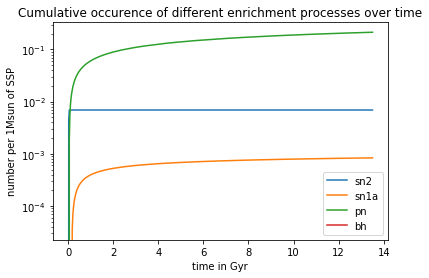

In [20]:
plt.plot(time,np.cumsum(y[fields[3]]),label = fields[3])
plt.plot(time,np.cumsum(y[fields[4]]),label = fields[4])
plt.plot(time,np.cumsum(y[fields[5]]),label = fields[5])
plt.plot(time,np.cumsum(y[fields[6]]),label = fields[6])
plt.title('Cumulative occurence of different enrichment processes over time')
plt.legend()
plt.xlabel('time in Gyr')
plt.ylabel('number per 1Msun of SSP')
plt.yscale('log')
print('These are no mass fractions but occurence rate per 1Msun of SSP.')
print('Over a Hubble time, per 1Msun of SSP we have approximately 0.1 Planetary nebula, 0.01 SNII, 0.001 SN1a. Black holes were not used in this SPP generation')

In [21]:
elements = ['Al', 'Ar', 'As', 'B', 'Be', 'Br', 'C', 'Ca', 'Cl', 'Co', 'Cr', 'Cu', 'F', 'Fe', 'Ga', 'Ge', 'H', 'He', 'K', 'Kr', 'Li', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Ne', 'Ni', 'O', 'P', 'Rb', 'S', 'Sc', 'Se', 'Si', 'Sr', 'Ti', 'V', 'Y', 'Zn', 'Zr']

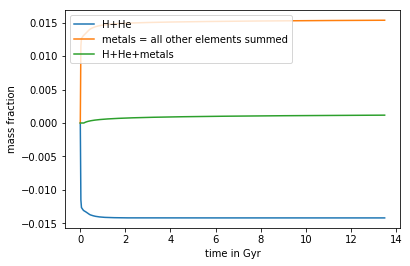

we see that all elements are synthesised from H. If we look at metals produced we see that 0.015 percent of an SSP is turned into metals within a Hubble time for a 0.01Z SSP.
my guess for the small discrepancy we see are hydrogen accreted onto dwarfs, or elements that are not part of the yields tables or numerical instabilities. I can look that up upon request


In [22]:
net_metals = np.zeros_like(y['Fe'])
for item in elements:
    if item not in ['H','He']:
        net_metals += np.cumsum(y[item])

plt.plot(time,np.cumsum(y['H'])+np.cumsum(y['He']), label = 'H+He')
plt.plot(time,net_metals,label = 'metals = all other elements summed')
plt.plot(time,net_metals+np.cumsum(y['H'])+np.cumsum(y['He']),label = 'H+He+metals')
plt.xlabel('time in Gyr')
plt.ylabel('mass fraction')
plt.legend()
plt.show()
plt.clf()
plt.close()
print('we see that all elements are synthesised from H. If we look at metals produced we see that 0.015 percent of an SSP is turned into metals within a Hubble time for a 0.01Z SSP.')
print('my guess for the small discrepancy we see are hydrogen accreted onto dwarfs, or elements that are not part of the yields tables or numerical instabilities. I can look that up upon request')

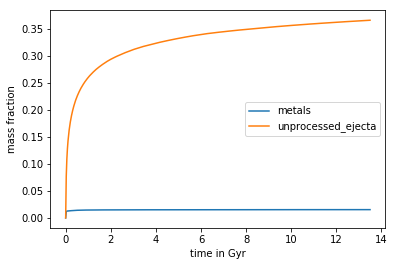

we see that most of the ejecta are truly unprocessed, i.e. it is returned what were the initial abundances of the SSP
only a tiny fraction new metals are ejected


In [23]:
plt.plot(time,net_metals,label = 'metals')
plt.plot(time,np.cumsum(y['unprocessed_ejecta']), label = 'unprocessed_ejecta')
plt.xlabel('time in Gyr')
plt.ylabel('mass fraction')
plt.legend()
plt.show()
plt.clf()
plt.close()
print('we see that most of the ejecta are truly unprocessed, i.e. it is returned what were the initial abundances of the SSP')
print('only a tiny fraction new metals are ejected')

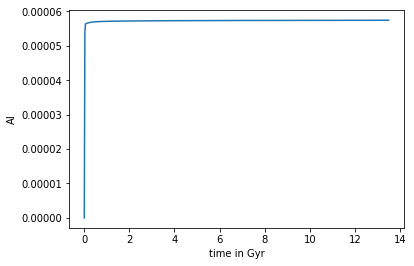

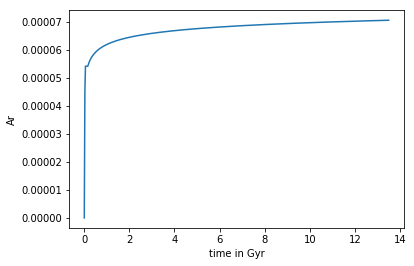

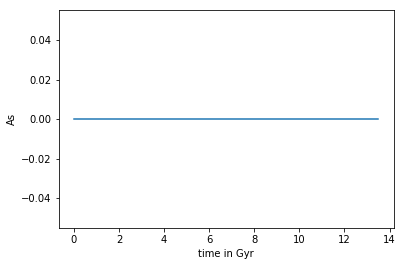

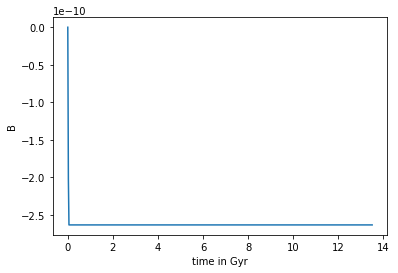

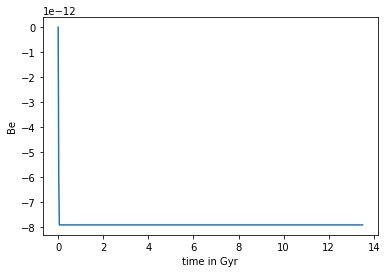

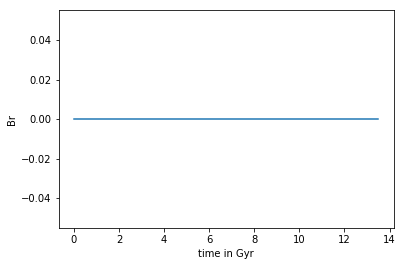

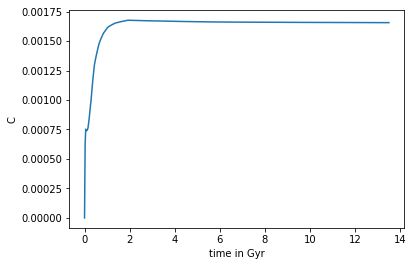

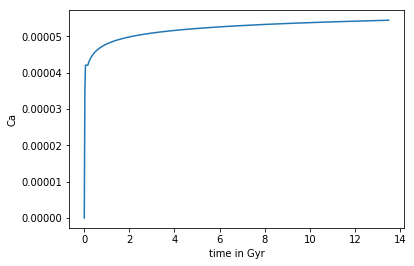

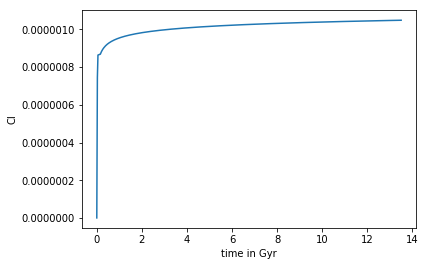

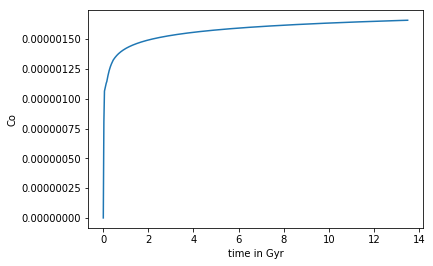

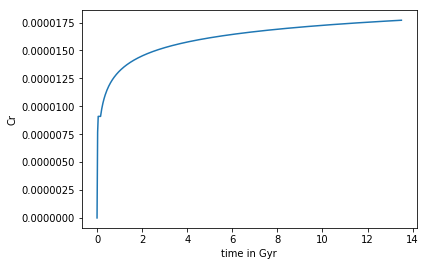

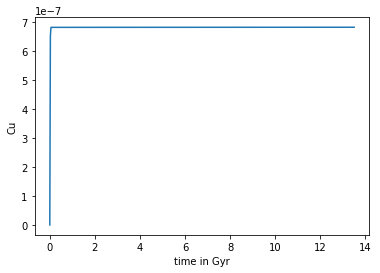

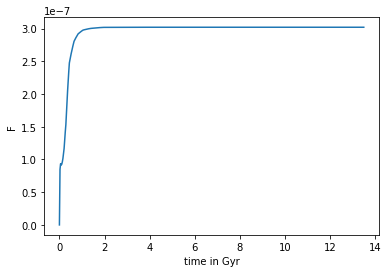

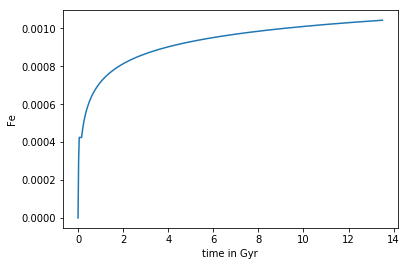

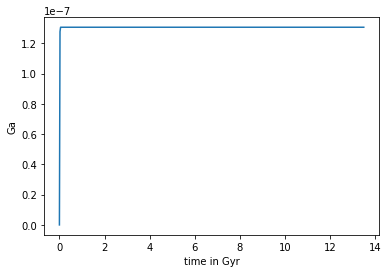

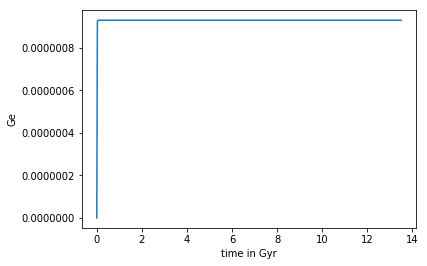

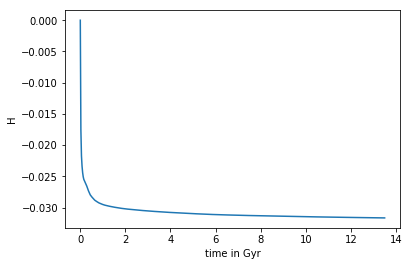

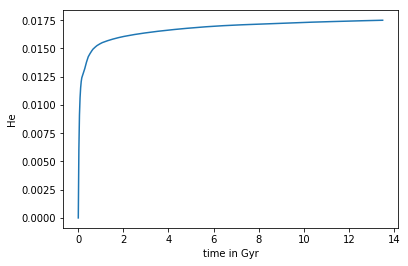

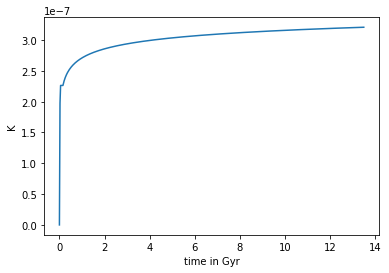

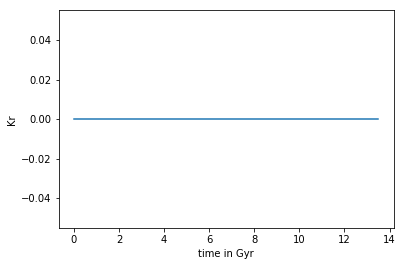

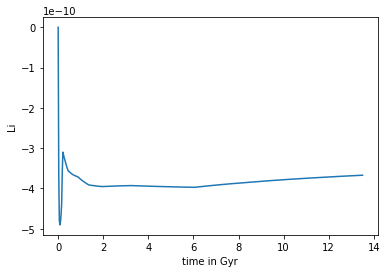

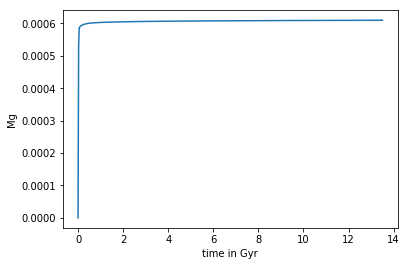

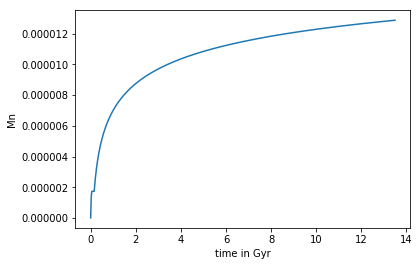

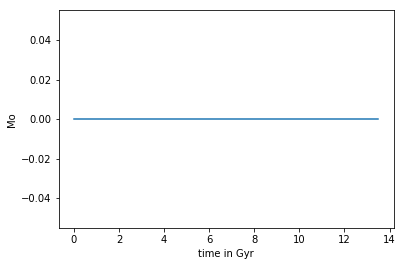

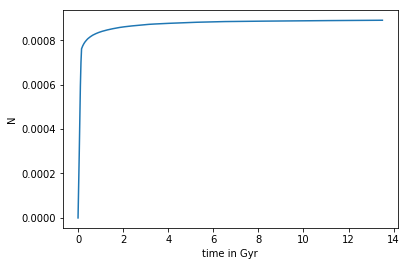

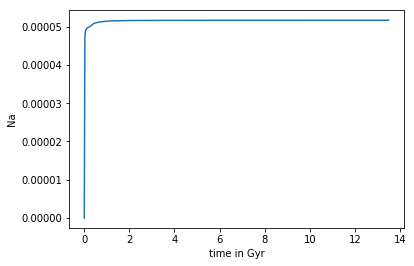

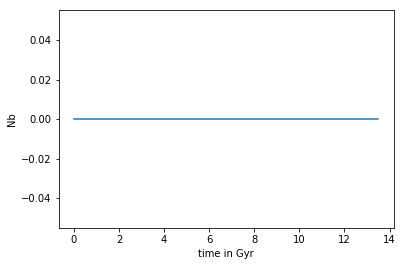

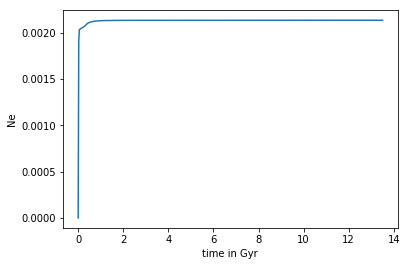

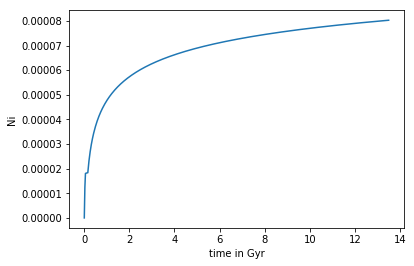

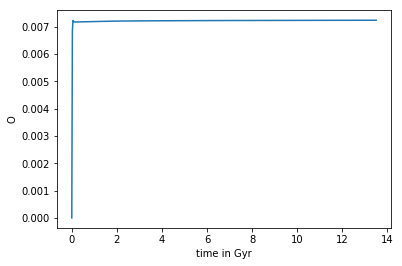

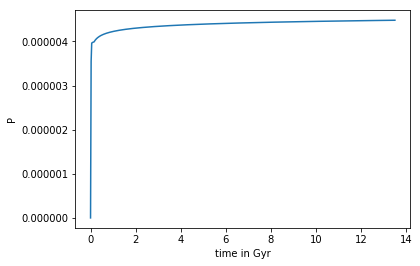

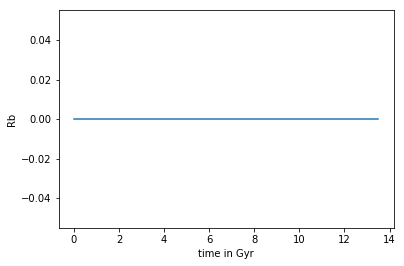

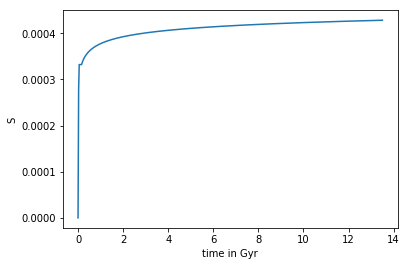

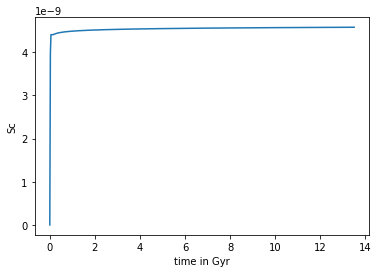

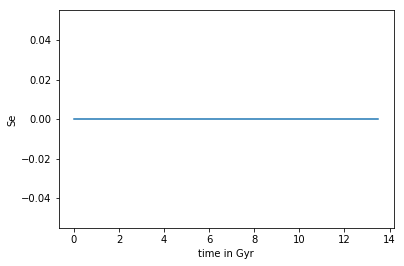

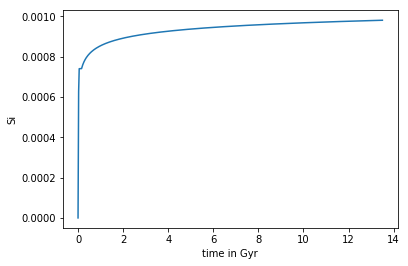

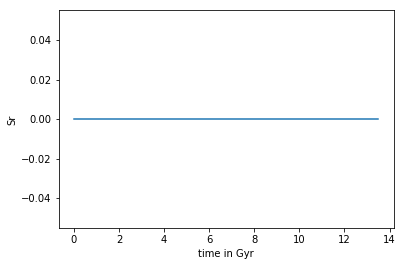

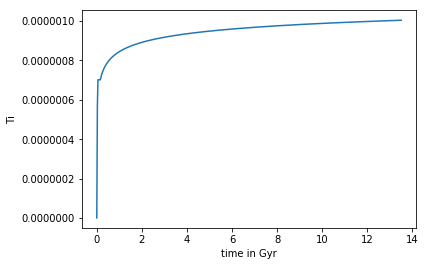

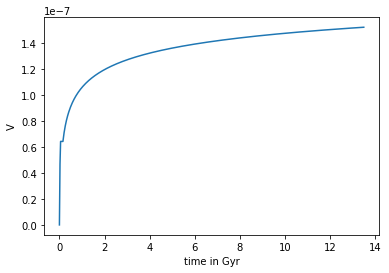

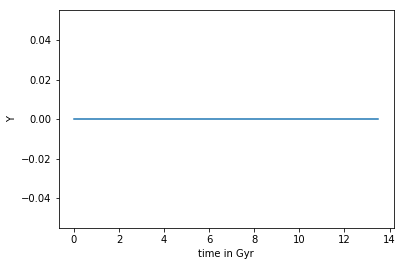

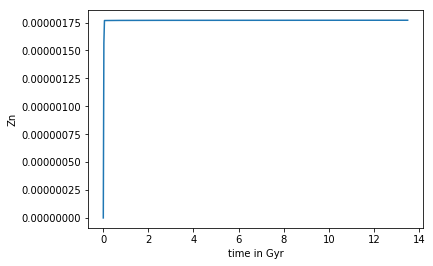

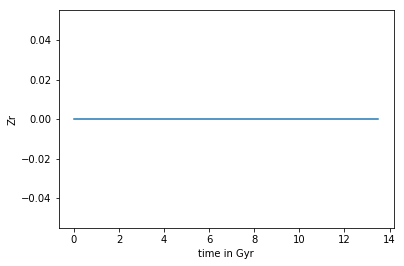

In [24]:
## Just for completeness all elements over time!
for i,element in enumerate(elements):
    plt.plot(time,np.cumsum(y[element]))
    plt.xlabel('time in Gyr')
    plt.ylabel(element)
    plt.show()
    plt.clf()
    plt.close()